## Space Data Analysis using DeepWalk

This project will be analysis articles from Wikipedia using DeepWalk.

First lets import the necessary packages.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

Now we input the data containing the titles of the articles

In [9]:
df = pd.read_csv("/Users/js/Downloads/wikipedia-biography-dataset-master/wikipedia-biography-dataset.z00", error_bad_lines=False)
df.head()

b'Skipping line 4: expected 1 fields, saw 7\nSkipping line 6: expected 1 fields, saw 2\nSkipping line 9: expected 1 fields, saw 2\nSkipping line 11: expected 1 fields, saw 2\nSkipping line 14: expected 1 fields, saw 2\nSkipping line 17: expected 1 fields, saw 2\nSkipping line 28: expected 1 fields, saw 4\nSkipping line 29: expected 1 fields, saw 2\nSkipping line 32: expected 1 fields, saw 2\nSkipping line 41: expected 1 fields, saw 2\nSkipping line 46: expected 1 fields, saw 3\nSkipping line 50: expected 1 fields, saw 3\nSkipping line 52: expected 1 fields, saw 3\nSkipping line 53: expected 1 fields, saw 2\nSkipping line 59: expected 1 fields, saw 2\nSkipping line 63: expected 1 fields, saw 2\nSkipping line 65: expected 1 fields, saw 2\nSkipping line 68: expected 1 fields, saw 2\nSkipping line 69: expected 1 fields, saw 2\nSkipping line 72: expected 1 fields, saw 3\nSkipping line 73: expected 1 fields, saw 2\nSkipping line 76: expected 1 fields, saw 2\nSkipping line 78: expected 1 fiel

ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


In [ ]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [ ]:
len(G)

In [37]:
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [38]:
get_randomwalk('space exploration', 10)

['space exploration',
 'u.s. space exploration history on u.s. stamps',
 'mars pathfinder',
 'viking program',
 'mariner 9',
 'timeline of artificial satellites and space probes',
 'timeline of solar system exploration',
 'space race',
 'space geostrategy',
 'asteroid mining']

In [39]:
# get list of all nodes from the graph
all_nodes = list(G.nodes())

random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))
        
# count of sequences
len(random_walks)

100%|██████████| 2088/2088 [00:00<00:00, 11490.60it/s]


10440

## DeepWalk
Let's train the skip-gram model using Word2Vec

In [40]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [41]:
# train skip-gram (word2vec) model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(985583, 1015620)

As an example, lets find the articles closest to space tourism.

In [42]:
model.similar_by_word('space tourism')

[('space flight participant', 0.8554407358169556),
 ('reduced-gravity aircraft', 0.7394824028015137),
 ('rocketship tours', 0.7304192781448364),
 ('satellite internet access', 0.7185593247413635),
 ('seti', 0.7162845134735107),
 ('space tourism society', 0.7142296433448792),
 ('astronaut training', 0.7136715054512024),
 ('aerospace architecture', 0.7133640050888062),
 ('commercial astronaut', 0.6963919401168823),
 ('space geostrategy', 0.6719893217086792)]

Define a bunch of terms to analyze similarities on

In [55]:
terms = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 
         'moon landing','space food', 'food systems on space exploration missions', 
         'meal, ready-to-eat','space law', 'metalaw', 'moon treaty', 
         'legal aspects of computing','astronaut training', 'reduced-gravity aircraft', 
         'space adaptation syndrome', 'micro-g environment']

Plot the vector embeddings into a two dimensional space.

In [56]:
def plot_nodes(word_list):
    X = model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

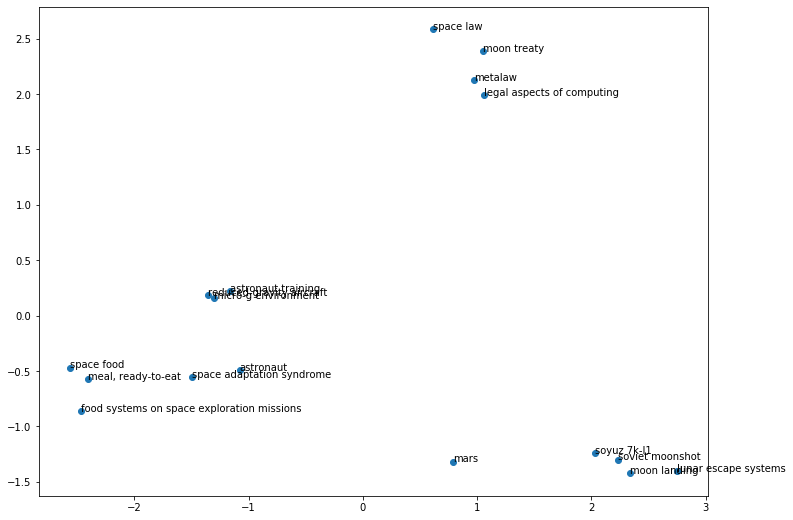

In [57]:
plot_nodes(terms)